In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import dask

import matplotlib.pyplot as plt


In [2]:
# pr_file = r'D://data/nclimgrid_daily/prcp_nClimGridDaily_1951-2024_USsouth.nc'
# tmax_file = r'D://data/nclimgrid_daily/tmax_nClimGridDaily_1951-2024_USsouth.nc'

pr_file = r'E://data/nclimgrid_daily/prcp_nClimGridDaily_1951-2024_USsouth.nc'
tmax_file = r'E://data/nclimgrid_daily/tmax_nClimGridDaily_1951-2024_USsouth.nc'



# chunks = {'time':-1,'lat':50,'lon':50}

# Steps

1) find the starting day of the calculation at each grid cell (KBDI initialization)
    - when the running sum of precip over a 1 week period is greater than 152mm (or 203?)
    - the starting day for calculating KBDI is the next day (after the week that qualifies above) 
2) calculate rr for the whole timeseries at each grid (the number of consecutive days with rain)
3) calculate Pnet of t
4) calculate Q of t0 using KBDI of t-1 = 0
5) calculate KBDI

# 1) KBDI Initialization date at each grid cell

Finding the first possible day at each grid where we can set the initial value of KBDI to zero. This requires a preceding wet period where at least 152mm of precip falls with 1 week.

In [3]:
pr=xr.open_dataset(pr_file).prcp.sel(time=slice('1951','1960'),lat=slice(30,32),lon=slice(-90,-88)).load()
pr

<xarray.DataArray 'prcp' (time: 3653, lat: 48, lon: 48)> Size: 34MB
array([[[ 0.       ,  0.       ,  0.       , ...,        nan,
                nan,        nan],
        [ 0.       ,  0.       ,  0.       , ...,        nan,
                nan,        nan],
        [       nan,  0.       ,  0.       , ...,        nan,
                nan,        nan],
        ...,
        [ 0.       ,  0.       ,  0.       , ...,  0.       ,
          0.       ,  0.       ],
        [ 0.       ,  0.       ,  0.       , ...,  0.       ,
          0.       ,  0.       ],
        [ 0.       ,  0.       ,  0.       , ...,  0.       ,
          0.       ,  0.       ]],

       [[ 0.       ,  0.       ,  0.       , ...,        nan,
                nan,        nan],
        [ 0.       ,  0.       ,  0.       , ...,        nan,
                nan,        nan],
        [       nan,  0.       ,  0.       , ...,        nan,
                nan,        nan],
...
        [15.6875   , 15.109375 , 14.96875  , ..., 17.328125 ,
         17.46875  , 14.8203125],
        [15.1875   , 14.8984375, 14.5703125, ..., 17.226562 ,
         17.039062 , 14.921875 ],
        [14.7265625, 14.3515625, 13.609375 , ..., 16.84375  ,
         15.6875   , 14.2421875]],

       [[13.40625  , 13.1875   , 13.0078125, ...,        nan,
                nan,        nan],
        [13.296875 , 13.0625   , 12.65625  , ...,        nan,
                nan,        nan],
        [       nan, 12.78125  , 12.65625  , ...,        nan,
                nan,        nan],
        ...,
        [ 7.953125 ,  7.359375 ,  6.96875  , ...,  4.2890625,
          4.0390625,  3.2734375],
        [ 7.71875  ,  7.3203125,  6.953125 , ...,  4.3984375,
          4.1484375,  3.453125 ],
        [ 7.6171875,  7.1484375,  6.59375  , ...,  4.453125 ,
          3.9921875,  3.421875 ]]], dtype=float32)
Coordinates:
  * time         (time) datetime64[ns] 29kB 1951-01-01 1951-01-02 ... 1960-12-31
  * lat          (lat) float32 192B 30.02 30.06 30.1 30.15 ... 31.9 31.94 31.98
  * lon          (lon) float32 192B -89.98 -89.94 -89.9 ... -88.1 -88.06 -88.02
    spatial_ref  int64 8B 0
Attributes:
    id:                /workspace/home2/home/imke.durre/active/live/products/...
    long_name:         Precipitation, daily total
    valid_max:         2000.0
    standard_name:     precipitation_amount
    naming_authority:  gov.noaa.ncei
    source:            GHCN-Daily CSV files 
    comment:           Values should be rounded to the nearest hundredth. Eac...
    units:             mm/day
    reference:         https://doi.org/10.1175/JTECH-D-22-0024.1
    valid_min:         0.0
    metadata_link:     https://doi.org/10.25921/c4gt-r169

1963 data points (grids) over land


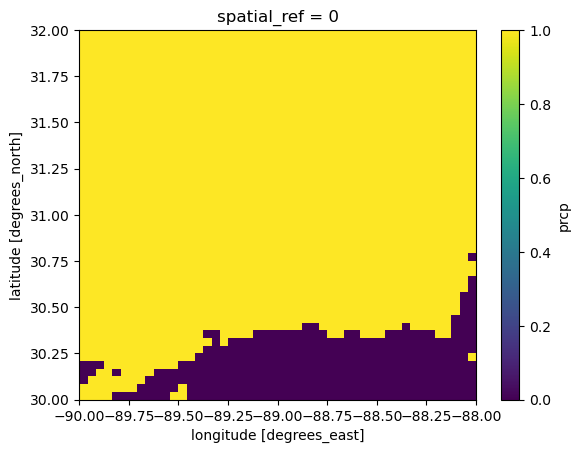

In [6]:
# make a land/sea 1/0 mask (to help us keep track of where the nans should be)
landmask=xr.where(np.isfinite(pr.mean('time')),1,0)
nlandpts = landmask.sum().data
print(f'{nlandpts} data points (grids) over land')
landmask.plot()

In [7]:
# create an integer time index since datetimes will give us some trouble
time_index=np.arange(0,len(pr.time)).astype('int')
pr.coords['time_index']=('time',time_index)
pr

<xarray.DataArray 'prcp' (time: 3653, lat: 48, lon: 48)> Size: 34MB
array([[[ 0.       ,  0.       ,  0.       , ...,        nan,
                nan,        nan],
        [ 0.       ,  0.       ,  0.       , ...,        nan,
                nan,        nan],
        [       nan,  0.       ,  0.       , ...,        nan,
                nan,        nan],
        ...,
        [ 0.       ,  0.       ,  0.       , ...,  0.       ,
          0.       ,  0.       ],
        [ 0.       ,  0.       ,  0.       , ...,  0.       ,
          0.       ,  0.       ],
        [ 0.       ,  0.       ,  0.       , ...,  0.       ,
          0.       ,  0.       ]],

       [[ 0.       ,  0.       ,  0.       , ...,        nan,
                nan,        nan],
        [ 0.       ,  0.       ,  0.       , ...,        nan,
                nan,        nan],
        [       nan,  0.       ,  0.       , ...,        nan,
                nan,        nan],
...
        [15.6875   , 15.109375 , 14.96875  , ..., 17.328125 ,
         17.46875  , 14.8203125],
        [15.1875   , 14.8984375, 14.5703125, ..., 17.226562 ,
         17.039062 , 14.921875 ],
        [14.7265625, 14.3515625, 13.609375 , ..., 16.84375  ,
         15.6875   , 14.2421875]],

       [[13.40625  , 13.1875   , 13.0078125, ...,        nan,
                nan,        nan],
        [13.296875 , 13.0625   , 12.65625  , ...,        nan,
                nan,        nan],
        [       nan, 12.78125  , 12.65625  , ...,        nan,
                nan,        nan],
        ...,
        [ 7.953125 ,  7.359375 ,  6.96875  , ...,  4.2890625,
          4.0390625,  3.2734375],
        [ 7.71875  ,  7.3203125,  6.953125 , ...,  4.3984375,
          4.1484375,  3.453125 ],
        [ 7.6171875,  7.1484375,  6.59375  , ...,  4.453125 ,
          3.9921875,  3.421875 ]]], dtype=float32)
Coordinates:
  * time         (time) datetime64[ns] 29kB 1951-01-01 1951-01-02 ... 1960-12-31
  * lat          (lat) float32 192B 30.02 30.06 30.1 30.15 ... 31.9 31.94 31.98
  * lon          (lon) float32 192B -89.98 -89.94 -89.9 ... -88.1 -88.06 -88.02
    spatial_ref  int64 8B 0
    time_index   (time) int64 29kB 0 1 2 3 4 5 ... 3647 3648 3649 3650 3651 3652
Attributes:
    id:                /workspace/home2/home/imke.durre/active/live/products/...
    long_name:         Precipitation, daily total
    valid_max:         2000.0
    standard_name:     precipitation_amount
    naming_authority:  gov.noaa.ncei
    source:            GHCN-Daily CSV files 
    comment:           Values should be rounded to the nearest hundredth. Eac...
    units:             mm/day
    reference:         https://doi.org/10.1175/JTECH-D-22-0024.1
    valid_min:         0.0
    metadata_link:     https://doi.org/10.25921/c4gt-r169

In [8]:
# sum precip in 7 day rolling windows
ndays=7
pr_thresh=152
pr_weeksum=pr.rolling(time=ndays,min_periods=4,center=False).sum()
pr_weeksum

<xarray.DataArray 'prcp' (time: 3653, lat: 48, lon: 48)> Size: 34MB
array([[[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
...
        [19.570312 , 18.632812 , 18.28125  , ..., 19.03125  ,
         19.3125   , 16.476562 ],
        [19.070312 , 18.507812 , 17.898438 , ..., 18.132812 ,
         18.820312 , 16.578125 ],
        [18.625    , 17.976562 , 16.851562 , ..., 17.75     ,
         16.585938 , 15.8125   ]],

       [[32.78125  , 32.015625 , 31.375    , ...,        nan,
                nan,        nan],
        [32.1875   , 31.671875 , 30.59375  , ...,        nan,
                nan,        nan],
        [       nan, 30.75     , 30.554688 , ...,        nan,
                nan,        nan],
        ...,
        [26.867188 , 25.414062 , 24.710938 , ..., 23.320312 ,
         23.351562 , 19.75     ],
        [26.171875 , 25.25     , 24.328125 , ..., 22.53125  ,
         22.96875  , 20.03125  ],
        [25.648438 , 24.578125 , 22.96875  , ..., 22.203125 ,
         20.578125 , 19.234375 ]]], dtype=float32)
Coordinates:
  * time         (time) datetime64[ns] 29kB 1951-01-01 1951-01-02 ... 1960-12-31
  * lat          (lat) float32 192B 30.02 30.06 30.1 30.15 ... 31.9 31.94 31.98
  * lon          (lon) float32 192B -89.98 -89.94 -89.9 ... -88.1 -88.06 -88.02
    spatial_ref  int64 8B 0
    time_index   (time) int64 29kB 0 1 2 3 4 5 ... 3647 3648 3649 3650 3651 3652
Attributes:
    id:                /workspace/home2/home/imke.durre/active/live/products/...
    long_name:         Precipitation, daily total
    valid_max:         2000.0
    standard_name:     precipitation_amount
    naming_authority:  gov.noaa.ncei
    source:            GHCN-Daily CSV files 
    comment:           Values should be rounded to the nearest hundredth. Eac...
    units:             mm/day
    reference:         https://doi.org/10.1175/JTECH-D-22-0024.1
    valid_min:         0.0
    metadata_link:     https://doi.org/10.25921/c4gt-r169

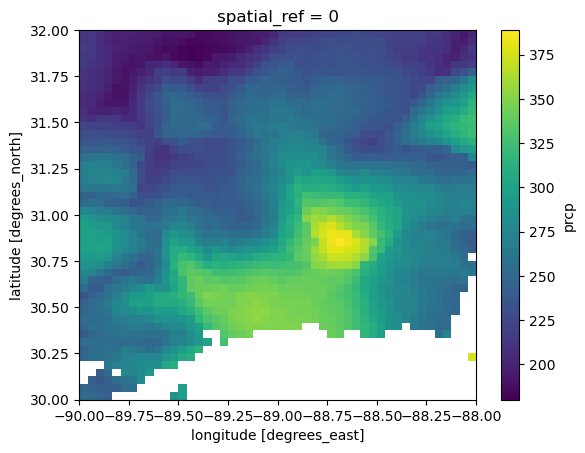

In [9]:
# look at the max 7 day sum
pr_weeksum.max('time').plot()

In [10]:
# get the first index time where the weekly sum meets the threshold
day_index = xr.where(pr_weeksum>pr_thresh,pr_weeksum.time_index,np.nan).min('time')
day_index

<xarray.DataArray (lat: 48, lon: 48)> Size: 18kB
array([[ 563.,  563.,  563., ...,   nan,   nan,   nan],
       [ 563.,  563.,  563., ...,   nan,   nan,   nan],
       [  nan, 1056.,  563., ...,   nan,   nan,   nan],
       ...,
       [  87.,   87.,   87., ...,   87.,   87.,   87.],
       [  87.,   87.,   87., ...,   87.,   87.,   87.],
       [  87.,   87.,   87., ...,   87.,   87.,   87.]])
Coordinates:
  * lat          (lat) float32 192B 30.02 30.06 30.1 30.15 ... 31.9 31.94 31.98
  * lon          (lon) float32 192B -89.98 -89.94 -89.9 ... -88.1 -88.06 -88.02
    spatial_ref  int64 8B 0

In [11]:
print(day_index.min().data, day_index.max().data)

assert day_index.min().data >= 7,f'found intialization at index {day_index.min().data.item()}'

77.0 1563.0


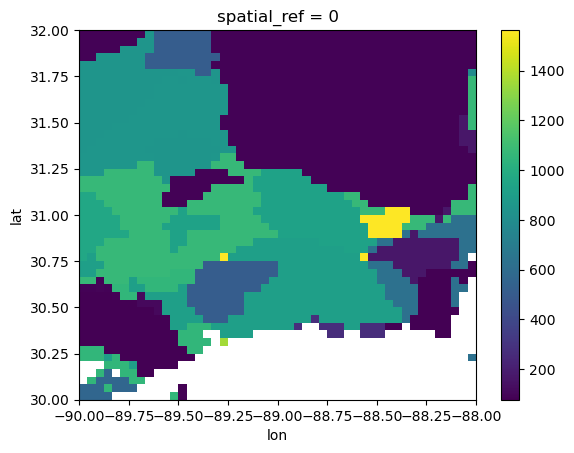

In [12]:
# look at the result
day_index.plot()

In [13]:
# are there any grids where we didn't find a time index (more nans than the landmask)

nnan_mask=landmask.sum().data # nans in the landmask (ocean points)
nnan_data=xr.where(np.isfinite(day_index),1,0).sum().data # nan grids in our initialization index (should be only ocean points)

assert nnan_mask == nnan_data, f'there are {nnan_data - nnan_mask} grid cells where a KBDI initialization index was not found'

figure out which day of the week/window is given in our index, is it the first day or last day?

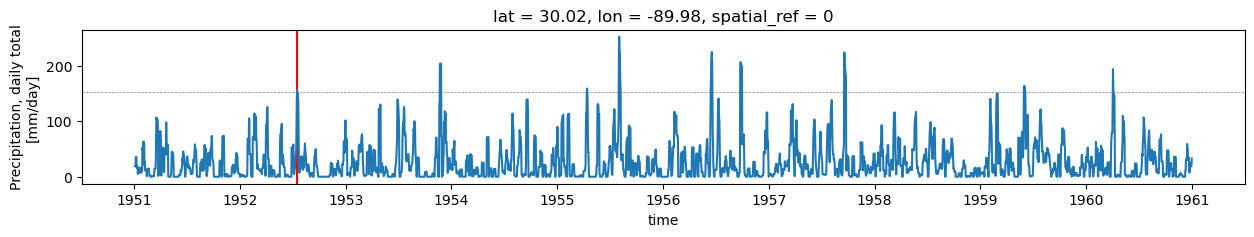

In [14]:
# look at rolling pr and plot the threshold as well as the date where the threshold is met for a single grid
fig=plt.figure(figsize=(15,2))
plt.axhline(y=pr_thresh,color='grey',linestyle='dashed',linewidth=0.5)  # threshold guide line
plt.axvline(x=pr_weeksum.time[day_index.isel(lat=0,lon=0).astype('int').item()].data,color='red')
pr_weeksum.isel(lat=0,lon=0).plot()

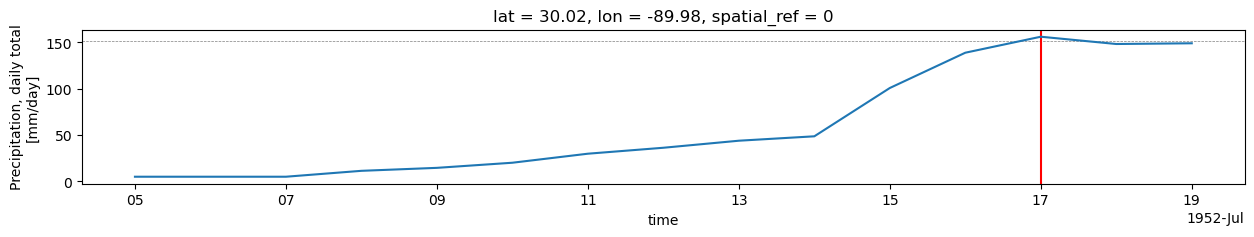

In [15]:
# zoom in
fig=plt.figure(figsize=(15,2))
plt.axhline(y=pr_thresh,color='grey',linestyle='dashed',linewidth=0.5)  # threshold guide line
plt.axvline(x=pr_weeksum.time[day_index.isel(lat=0,lon=0).astype('int').item()].data,color='red')
pr_weeksum.isel(lat=0,lon=0).sel(time=slice('1952-07-05','1952-07-19')).plot()

In [16]:
# do a little test of rolling on this grid for these dates
test=pr.isel(lat=0,lon=0).sel(time=slice('1952-07-05','1952-07-19')).rolling(time=ndays,min_periods=4,center=False).sum()
test

<xarray.DataArray 'prcp' (time: 15)> Size: 60B
array([        nan,         nan,         nan,   6.3671875,   9.578125 ,
        15.1015625,  29.953125 ,  36.375    ,  43.976562 ,  48.734375 ,
       100.875    , 138.96094  , 156.22656  , 148.36719  , 149.14844  ],
      dtype=float32)
Coordinates:
  * time         (time) datetime64[ns] 120B 1952-07-05 1952-07-06 ... 1952-07-19
    lat          float32 4B 30.02
    lon          float32 4B -89.98
    spatial_ref  int64 8B 0
    time_index   (time) int64 120B 551 552 553 554 555 ... 561 562 563 564 565
Attributes:
    id:                /workspace/home2/home/imke.durre/active/live/products/...
    long_name:         Precipitation, daily total
    valid_max:         2000.0
    standard_name:     precipitation_amount
    naming_authority:  gov.noaa.ncei
    source:            GHCN-Daily CSV files 
    comment:           Values should be rounded to the nearest hundredth. Eac...
    units:             mm/day
    reference:         https://doi.org/10.1175/JTECH-D-22-0024.1
    valid_min:         0.0
    metadata_link:     https://doi.org/10.25921/c4gt-r169

Because we chose min_periods=4 and the first 3 values are nan we can see that .rolling with center=False returns the sum of the 7 day window with the time label on the last day in the window. So the sum is of that day plus the preceding 6 days

**Therefore, this index/date is the KBDI initialization time t-1. The first KBDI will be computed one day after this at time t.**

# 2) rr, number of consecutive days with rain

In [17]:
# coding it up for a single grid first
prsub=pr.isel(lat=0,lon=0)
prsub

<xarray.DataArray 'prcp' (time: 3653)> Size: 15kB
array([ 0.      ,  0.      , 18.953125, ...,  0.      ,  2.21875 ,
       13.40625 ], dtype=float32)
Coordinates:
  * time         (time) datetime64[ns] 29kB 1951-01-01 1951-01-02 ... 1960-12-31
    lat          float32 4B 30.02
    lon          float32 4B -89.98
    spatial_ref  int64 8B 0
    time_index   (time) int64 29kB 0 1 2 3 4 5 ... 3647 3648 3649 3650 3651 3652
Attributes:
    id:                /workspace/home2/home/imke.durre/active/live/products/...
    long_name:         Precipitation, daily total
    valid_max:         2000.0
    standard_name:     precipitation_amount
    naming_authority:  gov.noaa.ncei
    source:            GHCN-Daily CSV files 
    comment:           Values should be rounded to the nearest hundredth. Eac...
    units:             mm/day
    reference:         https://doi.org/10.1175/JTECH-D-22-0024.1
    valid_min:         0.0
    metadata_link:     https://doi.org/10.25921/c4gt-r169

In [18]:
rainmask=xr.where(prsub>0,1,0)

In [19]:
# calculate number of consecutive rain days

# I got this code to interrupt a cumulative sum here:
# https://stackoverflow.com/questions/61753567/convert-cumsum-output-to-binary-array-in-xarray
rr=rainmask.cumsum()-rainmask.cumsum().where(rainmask == 0).ffill(dim='time').fillna(0)
rr

<xarray.DataArray 'prcp' (time: 3653)> Size: 29kB
array([0., 0., 1., ..., 0., 1., 2.])
Coordinates:
  * time         (time) datetime64[ns] 29kB 1951-01-01 1951-01-02 ... 1960-12-31
    lat          float32 4B 30.02
    lon          float32 4B -89.98
    spatial_ref  int64 8B 0
    time_index   (time) int64 29kB 0 1 2 3 4 5 ... 3647 3648 3649 3650 3651 3652

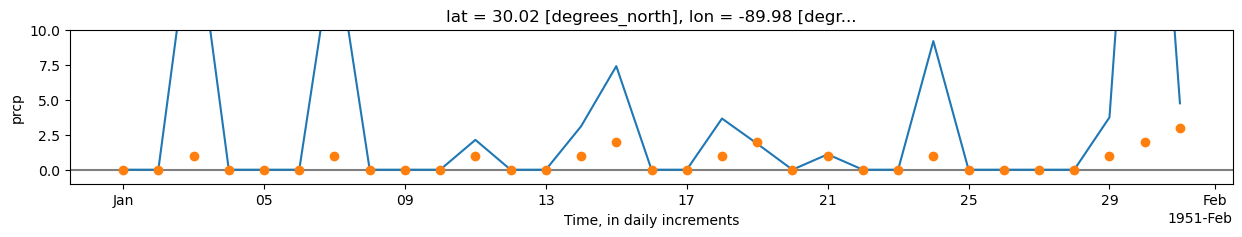

In [20]:
# let's see if it's really working
fig=plt.figure(figsize=(15,2))
plt.axhline(y=0,color='grey')  # threshold guide line
plt.ylim([-1,10])
prsub.sel(time=slice('1951-01-01','1951-01-31')).plot()
rr.sel(time=slice('1951-01-01','1951-01-31')).plot(marker='o',linewidth=0)

wow, ok it is working. blue line is daily precip, orange dots are the number of consecutive rain days.

Now do this to the whole array...

(3653, 48, 48)


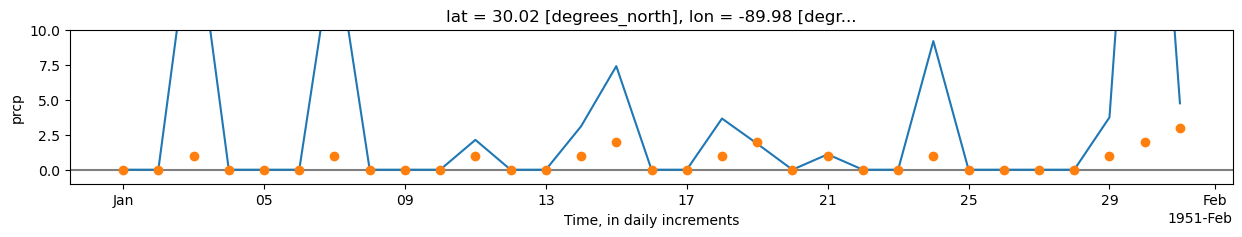

In [21]:
# same thing, whole array
rainmask=xr.where(pr>0,1,0)
rr=rainmask.cumsum('time')-rainmask.cumsum('time').where(rainmask == 0).ffill(dim='time').fillna(0)
print(rr.shape)

# plot should be identical
fig=plt.figure(figsize=(15,2))
plt.axhline(y=0,color='grey')  # threshold guide line
plt.ylim([-1,10])
pr.isel(lat=0,lon=0).sel(time=slice('1951-01-01','1951-01-31')).plot()
rr.isel(lat=0,lon=0).sel(time=slice('1951-01-01','1951-01-31')).plot(marker='o',linewidth=0)

plots for the test grid are identical

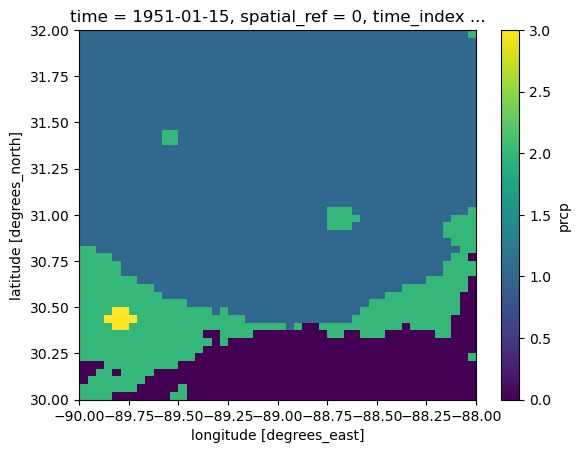

In [22]:
# check a single time in space
rr.sel(time='1951-01-15').plot()

we need to put the nans back

In [23]:
# put nans back
# .where reorders dims so we need .transpose to get original dim order back
rr=xr.where(landmask,rr,np.nan).transpose('time','lat','lon') 
# rr

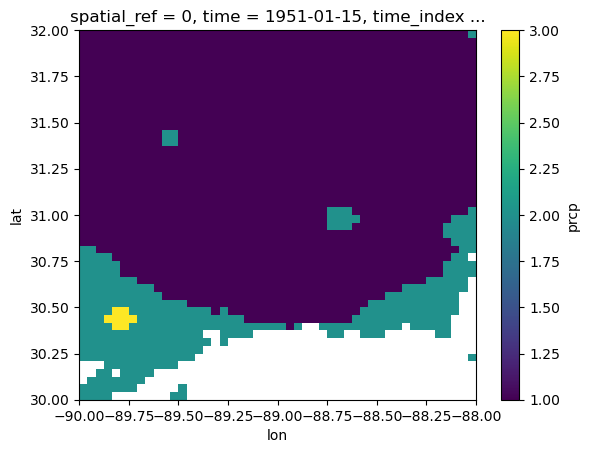

In [24]:
# check a single time in space
rr.sel(time='1951-01-15').plot()

looks good (note the different scales)

# 3) Pnet

In order to obtain net rainfall, 0.2 inch has to be subtracted from any daily rainfall amount exceeding 0.2 inch. In the case of consecutive days with rainfall, the 0.2 inch has to be subtracted on the exact day when the summed rainfall amount exceeds 0.2 inch. If the daily rainfall amount is smaller than 0.2, then net rainfall equals zero. Finally, net rainfall, expressed in hundredths of an inch, has to be subtracted from Q.

Pnet of t = max( 0, (P of t) - max(0, Plim - ∑ over i=1 to rr-1 of P of t−i)) 

I have no idea what this equation means, it doesn't seem to match the text description of how to calculate Pnet at all. Also, it's never explained what Plim is.

Approach:

- split the timeseries into categories (modify rr into the following categories)
    - category 0: days not in a consecutive rain event
        - days where no rain falls
        - days where less than 0.2 inch (5.08 mm) falls but is not part of a consecutive day rain event
        - days where more than 0.2 inch (5.08 mm) falls but is not part of a consecutive day rain event
    - category 1: days in a consecutive day rain event
        - this means any day that is in a consecutive day rain event regardless of over/under threshold
        - we'll have to loop through each consecutive rain event and
            - accumulate rainfall totals over consecutive days
            - rain amounts (lt 5.08 mm) on days before threshold is met should be set to 0
            - subtract 0.2 inches (5.08 mm) only from the exact day when threshold is met
            - rain amounts on days after threshold is met should remain unchanged and add to the accumulation

In [25]:
# this function creates two categories of rain days
# cat 0 is a day that is not part of a consecutive-day rainfall event
# cat 1 is a day that IS part of a consecutive-day rainfall event

def create_categories(rr_chunk,chunk_id):
    # for all consecutive rain events 
    # replace the third or greater day's value with an integer that is not 0, 1, or 2, we'll use 5
    cat_chunk=xr.where(rr_chunk>=3,5,rr_chunk)

    # we now need to find whether day 1's should be cat0 or cat1
    # we'll know the answer based on whether the following day is a 2
    
    # find all indexes of the second day of consecutive rain events
    day2_iii=np.argwhere(rr_chunk==2)

    # loop through the indexes found above and replace those 
    # day's values as well as the previous day's value with 5
    for i in range(day2_iii.shape[0]):
        # replace day 2's value with 5
        cat_chunk[day2_iii[i,0],day2_iii[i,1],day2_iii[i,2]] = 5    
        # replace day 1's value with 5
        cat_chunk[day2_iii[i,0]-1,day2_iii[i,1],day2_iii[i,2]] = 5    

    # days in a consecutive day rain event are 1
    # days not in a consecutive day rain event are 0
    # nan exists for non-data grids (over ocean cells)
    cat_chunk=xr.where(cat_chunk==1,0,cat_chunk)
    cat_chunk=xr.where(cat_chunk==5,1,cat_chunk)

    # make sure there are not more than 3 different values (0,1,nan) present
    assert len(np.unique(cat_chunk))<=3,f'too many category values {np.unique(cat_chunk)} in chunk id {chunk_id}' 

    return cat_chunk

In [26]:
# chunk over longitude for parallel processing
rr=rr.chunk({'time':-1,'lat':-1,'lon':3})
rr

<xarray.DataArray 'prcp' (time: 3653, lat: 48, lon: 48)> Size: 67MB
dask.array<xarray-<this-array>, shape=(3653, 48, 48), dtype=float64, chunksize=(3653, 48, 3), chunktype=numpy.ndarray>
Coordinates:
  * lat          (lat) float32 192B 30.02 30.06 30.1 30.15 ... 31.9 31.94 31.98
  * lon          (lon) float32 192B -89.98 -89.94 -89.9 ... -88.1 -88.06 -88.02
    spatial_ref  int64 8B 0
  * time         (time) datetime64[ns] 29kB 1951-01-01 1951-01-02 ... 1960-12-31
    time_index   (time) int64 29kB dask.array<chunksize=(3653,), meta=np.ndarray>

In [27]:
# delay the data chunks and get them into a 1D list
rr_delayed=rr.data.to_delayed().ravel()
len(rr_delayed)

16

In [28]:
%%time
# do the calculation

# list of delayed compute tasks (1 for each chunk)
task_list=[dask.delayed(create_categories)(rr_chunk,id) for id,rr_chunk in enumerate(rr_delayed)]

# compute in parallel
result_chunks=dask.compute(*task_list)

# concatenate results
cat_np=np.concatenate(result_chunks,axis=2)

# numpy to xarray
cat=xr.DataArray(cat_np,coords=rr.coords)
cat.shape

CPU times: total: 984 ms
Wall time: 538 ms


(3653, 48, 48)

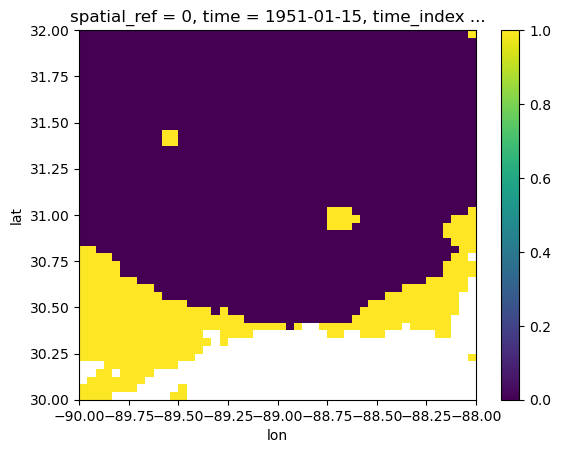

In [29]:
cat.sel(time='1951-01-15').plot()

We now have an array where every time at every grid falls into either cat 1 (day in consecutive rain event), cat 0 (day not in a consecutive rain event), or is nan. 

Next we have to loop in time to find the daily Pnet. Testing first on a single grid

In [30]:
# subset to single grid
rr_sub=rr[:,0,0].compute()
cat_sub=cat[:,0,0]
pr_sub = pr[:,0,0]
rr_sub.shape,cat_sub.shape,pr_sub.shape

((3653,), (3653,), (3653,))

In [31]:
# initialize to nan
Pnet = rr_sub.copy()
Pnet[:]=np.nan

In [32]:
# Pnet condition for days not in consecutive rain event
# subtract 5.08mm from precipitation amount
# and if negative, replace with 0
thresh = 5.08
Pnet = xr.where(cat_sub==0, pr_sub-thresh, Pnet)
Pnet = xr.where(Pnet<0,0,Pnet)

In [33]:
# now loop through consecutive rain events to find cumulative pr


# initializations
thresh_flag=False
accpr=0.

for i,(catval,prval) in enumerate(zip(cat_sub,pr_sub)):

    # set/reset accpr to 0 and threshold flag when not raining consec days
    if catval==0:
        accpr=0.
        thresh_flag=False

    # if consec day rain
    # subtract threshold where appropriate
    # and accumlate rainfall over the event    
    if catval==1:
        accpr=accpr+prval # accumulated precip
        # if not over the threshold yet, Pnet is 0
        if accpr<thresh and not thresh_flag:
            Pnet[i]=0
        # on the day the threshold is met, subtract the threshold amount and change flag    
        elif accpr>=thresh and not thresh_flag:
            accpr=accpr-thresh # modify accumulated precip
            Pnet[i]=accpr
            thresh_flag=True
        # any days after the threshold is met will accumulate with no limitations or subtractions   
        else:
            Pnet[i]=accpr            

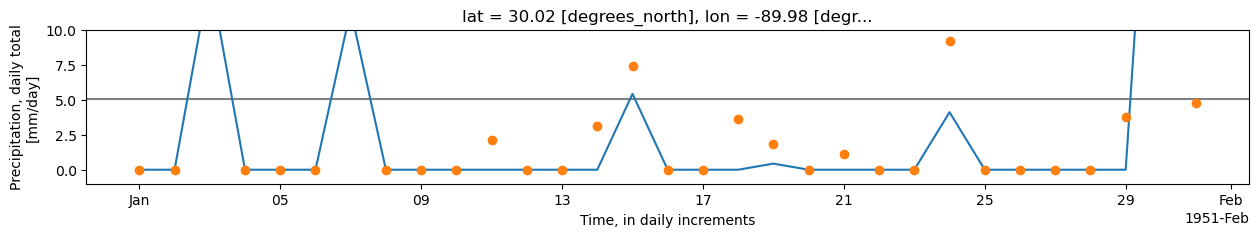

In [34]:
# plot should be identical
fig=plt.figure(figsize=(15,2))
plt.axhline(y=5.08,color='grey')  # threshold guide line
plt.ylim([-1,10])
Pnet.sel(time=slice('1951-01-01','1951-01-31')).plot()  # blue line
pr_sub.sel(time=slice('1951-01-01','1951-01-31')).plot(marker='o',linewidth=0)  # orange circle

Looks like it's working correctly. Now apply to whole array. This is a time loop that will have to be applied to every grid cell. We'll send 3D chunks of data to the function and loop through the timeseries for each grid cell

In [35]:
# function to calculate the 3D array Pnet

def calc_pnet(cat_arr,pr_arr):
    # initializations and constants
    thresh = 5.08
    thresh_flag=False
    accpr=0.
    
    # calc pnet where not consecutive day rain
    pnet = np.where(cat_arr==0, pr_arr-thresh, np.nan)
    pnet = np.where(pnet<0,0,pnet)

    # loops required for days in consec day rain
    for ilat in range(cat_arr.shape[1]):
        for ilon in range(cat_arr.shape[2]):
            for itime,(cat,pr) in enumerate(zip(cat_arr[:,ilat,ilon],pr_arr[:,ilat,ilon])):
    
                # set/reset accpr to 0 and threshold flag when not raining consec days
                if cat==0:
                    accpr=0.
                    thresh_flag=False
            
                # if consec day rain
                # subtract threshold where appropriate
                # and accumlate rainfall over the event    
                if cat==1:
                    accpr=accpr+pr # accumulated precip
                    # if not over the threshold yet, Pnet is 0
                    if (accpr<thresh) and (not thresh_flag):
                        pnet[itime,ilat,ilon]=0
                    # on the day the threshold is met, subtract the threshold amount and change flag    
                    elif (accpr>=thresh) and (not thresh_flag):
                        accpr=accpr-thresh # modify accumulated precip
                        pnet[itime,ilat,ilon]=accpr
                        thresh_flag=True
                    # any days after the threshold is met will accumulate with no limitations or subtractions   
                    else:
                        pnet[itime,ilat,ilon]=accpr  
    return pnet

In [36]:
# chunk, delay, ravel
chunk={'time':-1,'lat':-1,'lon':3}
cat=cat.chunk(chunk)
pr=pr.chunk(chunk)
cat_delayed=cat.data.to_delayed().ravel()
pr_delayed=pr.data.to_delayed().ravel()
len(cat_delayed),len(pr_delayed)

(16, 16)

In [37]:
%%time
# do the calculation

# list of delayed compute tasks (1 for each chunk)
task_list=[dask.delayed(calc_pnet)(cat_chunk,pr_chunk) for cat_chunk,pr_chunk in zip(cat_delayed,pr_delayed)]

# compute in parallel
result_chunks=dask.compute(*task_list)

# concatenate results
pnet_np=np.concatenate(result_chunks,axis=2)

# numpy to xarray
Pnet=xr.DataArray(pnet_np,coords=pr.coords)
Pnet.shape

CPU times: total: 3.16 s
Wall time: 2.94 s


(3653, 48, 48)

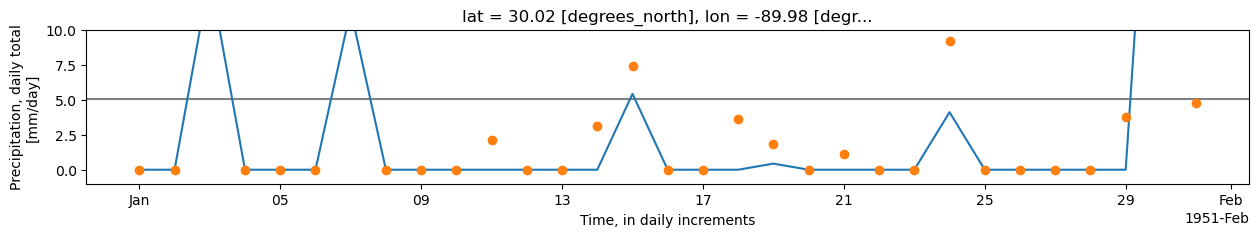

In [38]:
# results should be identical for the test grid we did earlier, let's check it
fig=plt.figure(figsize=(15,2))
plt.axhline(y=5.08,color='grey')  # threshold guide line
plt.ylim([-1,10])
Pnet.isel(lat=0,lon=0).sel(time=slice('1951-01-01','1951-01-31')).plot()  # blue line
pr.isel(lat=0,lon=0).sel(time=slice('1951-01-01','1951-01-31')).plot(marker='o',linewidth=0)  # orange circle

yes results are the same, everything working

now we need to fill Pnet with nan for times before the KBDI initialization date at each grid cell

In [39]:
def fill_nan_times(pnet_arr,init_ind,landmask):
   
    # get rid of nans and convert to integer
    init_ind=xr.where(~np.isfinite(init_ind),0,init_ind).astype('int').data

    # loop through grids and replace all values before the init index at each cell with nan
    for ilat in range(pnet_arr.shape[1]):
        for ilon in range(pnet_arr.shape[2]):
            pnet_arr[0:init_ind[ilat,ilon]+1,ilat,ilon]=np.nan

    # put any landmask nans back
    pnet_arr=xr.where(landmask,pnet_arr,np.nan)
    return pnet_arr

In [40]:
print(Pnet.shape,day_index.shape,landmask.shape)
chunk2D = {'lat':-1,'lon':3}

Pnet_delayed = Pnet.chunk(chunk).data.to_delayed().ravel()
day_index_delayed = day_index.chunk(chunk2D).data.to_delayed().ravel()
landmask_delayed = landmask.chunk(chunk2D).data.to_delayed().ravel()
print(len(Pnet_delayed),len(day_index_delayed),len(landmask_delayed))

(3653, 48, 48) (48, 48) (48, 48)
16 16 16


In [41]:
%%time
# do the calculation

# list of delayed compute tasks (1 for each chunk)
task_list=[dask.delayed(fill_nan_times)(pnet_chunk,dayind_chunk,mask_chunk) for pnet_chunk,dayind_chunk,mask_chunk in zip(Pnet_delayed,day_index_delayed,landmask_delayed)]

# compute in parallel
result_chunks=dask.compute(*task_list)

# concatenate results
pnet_np=np.concatenate(result_chunks,axis=2)

# numpy to xarray
Pnet=xr.DataArray(pnet_np,coords=pr.coords)
Pnet.shape

CPU times: total: 62.5 ms
Wall time: 55.8 ms


(3653, 48, 48)

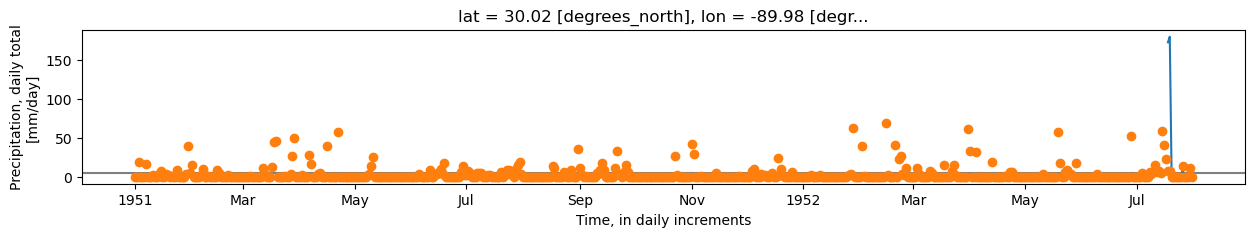

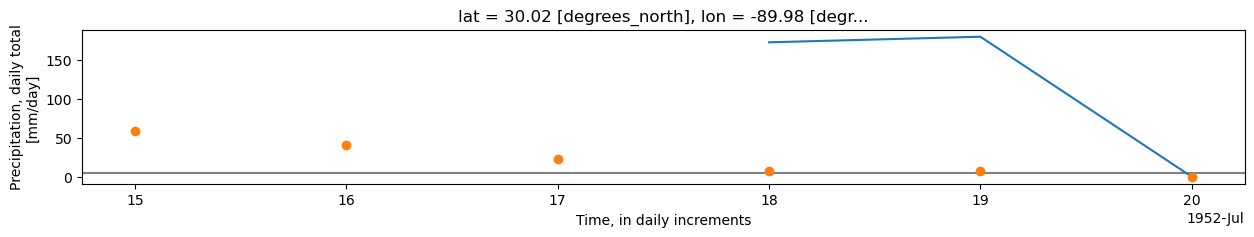

In [42]:
# results should show no blue line until one day after the initialization index
# for grid 0,0 the init index is the 17th of July 1952 
# so our blue line should start on Jul 18, 1952
fig=plt.figure(figsize=(15,2))
plt.axhline(y=5.08,color='grey')  # threshold guide line
Pnet.isel(lat=0,lon=0).sel(time=slice('1951-01-01','1952-07-31')).plot()  # blue line
pr.isel(lat=0,lon=0).sel(time=slice('1951-01-01','1952-07-31')).plot(marker='o',linewidth=0)  # orange circle

fig=plt.figure(figsize=(15,2))
plt.axhline(y=5.08,color='grey')  # threshold guide line
Pnet.isel(lat=0,lon=0).sel(time=slice('1952-07-15','1952-07-20')).plot()  # blue line
pr.isel(lat=0,lon=0).sel(time=slice('1952-07-15','1952-07-20')).plot(marker='o',linewidth=0)  # orange circle

filling nan like this will allow us to apply the same KBDI calculation at each time from time 0 and the result will be nan at all grids before the KBDI initialization index

# 4) load tmax data and calc mean annual precip

In [45]:
tmax=xr.open_dataset(tmax_file).tmax.sel(time=slice('1951','1960'),lat=slice(30,32),lon=slice(-90,-88)).load()
tmax


<xarray.DataArray 'tmax' (time: 3653, lat: 48, lon: 48)> Size: 34MB
array([[[16.28125  , 16.210938 , 16.148438 , ...,        nan,
                nan,        nan],
        [16.148438 , 16.039062 , 16.09375  , ...,        nan,
                nan,        nan],
        [       nan, 15.9609375, 15.953125 , ...,        nan,
                nan,        nan],
        ...,
        [11.3515625, 11.296875 , 11.03125  , ..., 12.9921875,
         12.7578125, 12.6796875],
        [10.9765625, 11.1328125, 11.109375 , ..., 13.       ,
         13.046875 , 12.9609375],
        [10.9296875, 10.90625  , 11.0078125, ..., 13.       ,
         12.9609375, 12.8515625]],

       [[20.59375  , 20.328125 , 19.648438 , ...,        nan,
                nan,        nan],
        [20.5625   , 20.351562 , 20.171875 , ...,        nan,
                nan,        nan],
        [       nan, 20.4375   , 20.320312 , ...,        nan,
                nan,        nan],
...
        [15.9765625, 16.101562 , 16.046875 , ..., 16.789062 ,
         16.523438 , 16.476562 ],
        [15.7421875, 15.8671875, 15.9375   , ..., 16.679688 ,
         16.632812 , 16.40625  ],
        [15.5703125, 15.65625  , 15.78125  , ..., 16.53125  ,
         16.46875  , 16.28125  ]],

       [[15.1015625, 15.046875 , 15.0234375, ...,        nan,
                nan,        nan],
        [14.921875 , 14.84375  , 14.75     , ...,        nan,
                nan,        nan],
        [       nan, 14.6484375, 14.5703125, ...,        nan,
                nan,        nan],
        ...,
        [11.390625 , 11.4375   , 11.3203125, ..., 12.0625   ,
         11.890625 , 11.953125 ],
        [11.2578125, 11.328125 , 11.328125 , ..., 12.       ,
         12.0390625, 11.90625  ],
        [11.21875  , 11.2265625, 11.2890625, ..., 11.8984375,
         11.9296875, 11.84375  ]]], dtype=float32)
Coordinates:
  * time         (time) datetime64[ns] 29kB 1951-01-01 1951-01-02 ... 1960-12-31
  * lat          (lat) float32 192B 30.02 30.06 30.1 30.15 ... 31.9 31.94 31.98
  * lon          (lon) float32 192B -89.98 -89.94 -89.9 ... -88.1 -88.06 -88.02
    spatial_ref  int64 8B 0
Attributes:
    id:                /workspace/home2/home/imke.durre/active/live/products/...
    long_name:         Temperature, daily maximum
    valid_max:         100.0
    standard_name:     air_temperature
    naming_authority:  gov.noaa.ncei
    source:            GHCN-Daily CSV files 
    comment:           Values should be rounded to the nearest hundredth. Eac...
    units:             degree_Celsius
    reference:         https://doi.org/10.1175/JTECH-D-22-0024.1
    valid_min:         -100.0
    metadata_link:     https://doi.org/10.25921/c4gt-r169

In [55]:
mean_ann_pr = pr.resample(time='YE').sum(min_count=10).mean('time').compute()
mean_ann_pr

<xarray.DataArray 'prcp' (lat: 48, lon: 48)> Size: 9kB
array([[1450.7656, 1453.2047, 1456.6179, ...,       nan,       nan,
              nan],
       [1452.0852, 1453.4812, 1459.4172, ...,       nan,       nan,
              nan],
       [      nan, 1457.8008, 1463.1125, ...,       nan,       nan,
              nan],
       ...,
       [1325.0641, 1327.8625, 1330.6781, ..., 1330.9313, 1352.9359,
        1363.1531],
       [1332.6735, 1324.5758, 1320.5446, ..., 1310.443 , 1326.5898,
        1340.675 ],
       [1327.2594, 1325.7922, 1318.5875, ..., 1302.6656, 1305.9554,
        1326.3047]], dtype=float32)
Coordinates:
  * lat          (lat) float32 192B 30.02 30.06 30.1 30.15 ... 31.9 31.94 31.98
  * lon          (lon) float32 192B -89.98 -89.94 -89.9 ... -88.1 -88.06 -88.02
    spatial_ref  int64 8B 0

# 4) Calculate KBDI 

using SI units mm and C
$$
KBDI_{t} = Q_{t} + \frac{(203.2 - Q_{t}) (0.968 e^{0.0875 T_{t} + 1.5552} - 8.30) Δt}{1 + 10.88 e^{-0.001736 P}} * 10^{-3}
$$

$Q_{t}$ = $KBDI_{t-1}$ − $Pnet_{t}$

where: 

$KBDI_{t-1}$ is intialized to 0 everywhere at whatever time meets the wet condition criteria

In [43]:
# we need integers to use the array day_index for indexing
# so we temporarily need to replace nans over ocean points with 0
# we'll put them back later
day_index_nonan = xr.where(~np.isfinite(day_index),0,day_index).astype('int').data
np.unique(day_index_nonan)

array([   0,   77,   87,   91,  111,  167,  169,  268,  269,  509,  510,
        563,  623,  624,  626,  627,  787,  850,  854,  855,  856,  909,
        910,  911,  933,  934,  965, 1056, 1070, 1073, 1074, 1355, 1561,
       1563])

In [64]:
# initialize KBDI array to all nan
KBDI_np= pr.copy().compute().data
KBDI_np[:,:,:]=np.nan

# identify the KBDI initialization date by filling 0 at the appropriate index for each cell
# this is some real fancy indexing that will fill 0 at one single time in the timeseries for each grid cell
# indexing this fancy only works on numpy arrays, not xarray structures, not dask arrays
KBDI_np[day_index_nonan,np.arange(KBDI_np.shape[1])[:,None],np.arange(KBDI_np.shape[2])] = 0

# put the ocean nans back using the landmask
KBDI_np=np.where(landmask,KBDI_np,np.nan)

# expecting shape (3653, 48, 48), unique vals (0,np.nan), and 1963 data points = 0
KBDI_np.shape,np.unique(KBDI_np,return_counts=True)

((3653, 48, 48), (array([ 0., nan], dtype=float32), array([   1963, 8414549])))

everything is as expected so far

In [65]:
# try the equations for a single time first
# at time t = 1
Q = KBDI_np[0,:,:] - Pnet[1,:,:]
print(Q.shape,np.unique(Q)) # should be all nan

term2_numerator = (203.2 - Q) * (0.969 * np.exp(0.0875*tmax[1,:,:]+1.5552) - 8.3)
term2_denominator = 1 + 10.88 * np.exp(-0.001736*mean_ann_pr)

KBDI_np[1,:,:]= Q + (term2_numerator/term2_denominator)*10E-3

# results should be all nan or 0
np.unique(KBDI_np)

(48, 48) [nan]


array([ 0., nan], dtype=float32)

In [66]:
%%time
for it in range(1,KBDI_np.shape[0]):
    Q = KBDI_np[it-1,:,:] - Pnet[it,:,:]
    term2_numerator = (203.2 - Q) * (0.969 * np.exp(0.0875*tmax[it,:,:]+1.5552) - 8.3)
    term2_denominator = 1 + 10.88 * np.exp(-0.001736*mean_ann_pr)
    KBDI_np[it,:,:]= Q + (term2_numerator/term2_denominator)*10E-3
    del Q, term2_numerator, term2_denominator

CPU times: total: 8.52 s
Wall time: 8.49 s


In [67]:
# back to xarray
KBDI=xr.DataArray(KBDI_np,coords=pr.coords)

In [68]:
np.unique(KBDI)

array([nan], dtype=float32)

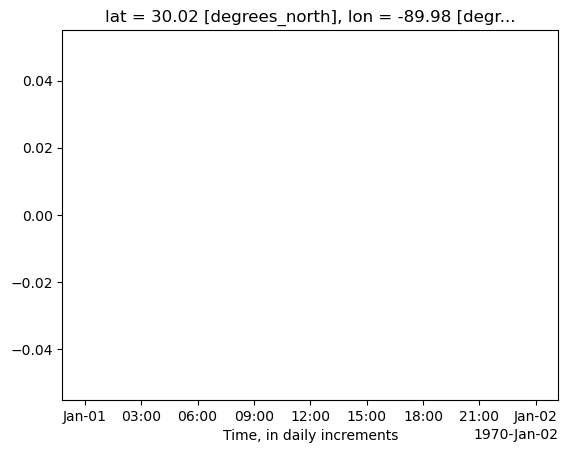

In [62]:
KBDI[:,0,0].plot()

In [ ]:
time_indices = np.random.randint(0, 10, (5, 5))
time_indices

In [ ]:
np.arange(5)[:, None]

In [ ]:
data = np.random.rand(10, 5, 5)

In [ ]:
data[time_indices,np.arange(5)[:,None],np.arange(5)]

In [ ]:
data[7,0,0],data[9,0,1],data[1,1,0]

In [ ]:
Pnet.data[day_index_nonan+1,np.arange(len(Pnet.lat))[:,None],np.arange(len(Pnet.lon))]

In [ ]:
Pnet.time[int(day_index.max())]

In [ ]:
test=Pnet.copy()
test[:day_index_nonan+1,np.arange(len(Pnet.lat))[:,None],np.arange(len(Pnet.lon))] = np.nan
test

In [ ]:
KBDI of t = Q + ( (800 - Q) * (0.968 * e^(0.048 6 *T) - 8.30) - 8.30) * Δt ) / ( 1 + 10.88 * e^(-0.0441 * P) ) * 10^(-3

In [ ]:
Pnet_sub=rr[:,0,0].copy()
Pnet_sub[:]=np.nan
rr_sub=rr[:,0,0]
Pnet_sub

In [ ]:
rr_sub[0:20].data

In [ ]:
for d in range(len(Pnet_sub.time[0:20])):
    # has there been rain for consecutive days
    if rr_sub[d] >= 2:
        
    for nd in range(int(rr_sub[d].data)-int(rr_sub[d].data),int(rr_sub[d].data)):
        print(d,nd)
        